# Dano's pyRiemann  notebook

In this notebook, I will try and use pyRiemann to perform feature selection and test what traditional ML algorithms would be useful to predict cognitive performance from EEG data in Neurodoro

In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from os import walk
from os import listdir
from os.path import isfile, join
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from tpot import TPOTClassifier
from math import sqrt
import pyriemann
from mne import create_info, concatenate_raws
from mne.io import RawArray
from mne.channels import read_montage
from glob import glob
from pyriemann.utils.viz import plt, plot_confusion_matrix, plot_embedding
from pyriemann.estimation import Covariances, HankelCovariances
from pyriemann.tangentspace import TangentSpace
from pyriemann.clustering import Potato

Notes:
- try alpha and beta common spatial pattern technique (supervised covariance feature extraction)
- Spoc source power of comodulation better for regression (doesn't use Riemannian space)

1. Concat all raw datasets together
2. Use Knearest Neighbors in pipeline

In [137]:
# Data has been collected, let's import it

concentrated_data = pd.read_csv("../muse-data/Dano_Coding.csv", header=0, index_col=False)
relaxed_data = pd.read_csv("../muse-data/Dano_Youtubing.csv", header=0, index_col=False)

In [138]:
concentrated_data.drop(['Unnamed: 5', 'Timestamp (ms)'], axis=1, inplace=True)
relaxed_data.drop(['Unnamed: 5', 'Timestamp (ms)'], axis=1, inplace=True)

In [139]:
concentrated_data.insert(0, 'Class', "1")
relaxed_data.insert(0, 'Class', "0")

In [140]:
data = concentrated_data.append(relaxed_data)

In [141]:
sfreq = 256

# name of each channels 
ch_names = ['Class', 'TP9', 'FP1', 'FP2', 'TP10']

# type of each channels
ch_types = ['stim'] + ['eeg'] * 4
montage = read_montage('standard_1005')

# get data and exclude Aux channel
data = data.values.T

# convert in Volts (from uVolts)
#data[:-1] *= 1e-6

# create mne objects
info = create_info(ch_names=ch_names, ch_types=ch_types, sfreq=sfreq, montage=montage)
raw = (RawArray(data=data, info=info))

Creating RawArray with float64 data, n_channels=5, n_times=131352
    Range : 0 ... 131351 =      0.000 ...   513.090 secs
Ready.


tmax defaults to 60. in 0.14 but will change to np.inf in 0.15. Set it explicitly to avoid this warning
Effective window size : 8.000 (s)


<ipython-input-142-39b392d59ea0>:3: DeprecationWarning: tmax defaults to 60. in 0.14 but will change to np.inf in 0.15. Set it explicitly to avoid this warning
  raw.plot_psd(picks=[1]);
/home/dano/anaconda3/lib/python3.6/site-packages/mne/viz/raw.py:614: DeprecationWarning: In version 0.15 average will default to False and spatial_colors will default to True.
  'spatial_colors will default to True.', DeprecationWarning)


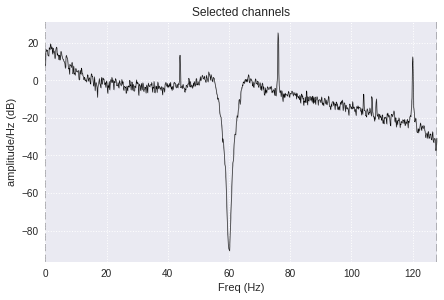

In [142]:
## Plot the PSD of the EEG data just to make sure it looks alright

raw.plot_psd(picks=[1]);


In [143]:
raw.filter(2, 50, method='iir')

Setting up band-pass filter from 2 - 50 Hz


<RawArray  |  None, n_channels x n_times : 5 x 131352 (513.1 sec), ~5.0 MB, data loaded>

## Epochs

In [144]:
from mne import make_fixed_length_events, Epochs

# Make an events array with epoch times every .5 seconds
event = make_fixed_length_events(raw, 1, duration=0.5)

# Make an epochs array object from the raw dataset with events array event, length of 2 seconds
epochs = Epochs(raw, event, tmin=0, tmax=2, preload=True)

epochs

1026 matching events found
0 projection items activated
Loading data for 1026 events and 513 original time points ...
3 bad epochs dropped


<Epochs  |  n_events : 1023 (all good), tmin : 0.0 (s), tmax : 2.0 (s), baseline : (None, 0), ~20.0 MB, data loaded>

In [145]:
X = epochs.copy().pick_types(eeg=True).get_data()

y = epochs.copy().pick_types(eeg=False, stim=True).get_data().mean(axis=2)
print(X.shape, y.shape)

(1023, 4, 513) (1023, 1)


In [146]:
# Let's transform our data into a covariance matrix and a tangentspace
covs = Covariances().fit_transform(X)
tans = TangentSpace().fit_transform(covs)
potato = Potato().fit_transform(covs)

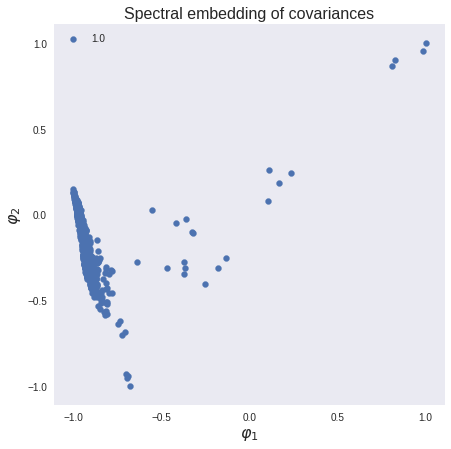

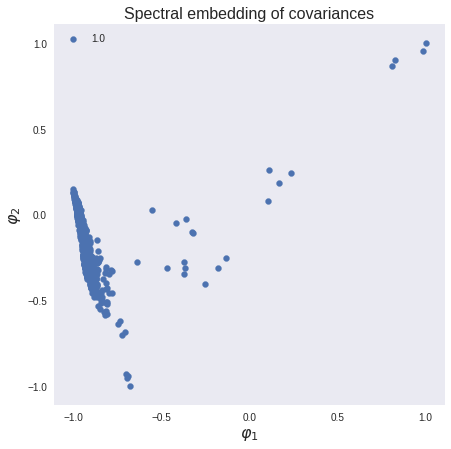

In [147]:
# Now that we have our data setup for sklearn in X and y, let's visualize it

plot_embedding(covs)

In [148]:
# Create a TPOTClassifier that will run for 10 generations

pipeline_optimizer = make_pipeline(Covariances(), TangentSpace(), TPOTClassifier(generations=10, population_size=30, cv=5,
                                    random_state=42, verbosity=3))

# Fit this baby! Takes a long time to run

pipeline_optimizer.fit(X, y)  
  
# See what kind of score we get
print(pipeline_optimizer.score(X, y))

29 operators have been imported by TPOT.


/home/dano/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


_pre_test decorator: _generate: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True
_pre_test decorator: _generate: num_test=0 Input X must be non-negative
_pre_test decorator: _generate: num_test=1 Input X must be non-negative
_pre_test decorator: _generate: num_test=0 Input X must be non-negative
_pre_test decorator: _generate: num_test=0 Input X must be non-negative
_pre_test decorator: _generate: num_test=0 Input X must be non-negative
_pre_test decorator: _generate: num_test=0 Input X must be non-negative
_pre_test decorator: _generate: num_test=0 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False


Optimization Progress:   0%|          | 0/330 [00:00<?, ?pipeline/s]

_pre_test decorator: _generate: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True


Optimization Progress:   8%|▊         | 28/330 [00:08<00:09, 33.01pipeline/s]

_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True
_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True
_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True
_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


Optimization Progress:  17%|█▋        | 55/330 [00:09<00:21, 12.58pipeline/s]

Generation 1 - Current Pareto front scores:
1	inf	DecisionTreeClassifier(input_matrix, DecisionTreeClassifier__criterion=DEFAULT, DecisionTreeClassifier__max_depth=7, DecisionTreeClassifier__min_samples_leaf=11, DecisionTreeClassifier__min_samples_split=12)



Optimization Progress:  17%|█▋        | 55/330 [00:11<00:21, 12.58pipeline/s]

_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


Optimization Progress:  17%|█▋        | 55/330 [00:18<00:21, 12.58pipeline/s]

_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative
_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative
_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative
_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative


Optimization Progress:  26%|██▌       | 85/330 [00:27<01:41,  2.42pipeline/s]

Generation 2 - Current Pareto front scores:
1	inf	DecisionTreeClassifier(input_matrix, DecisionTreeClassifier__criterion=DEFAULT, DecisionTreeClassifier__max_depth=7, DecisionTreeClassifier__min_samples_leaf=11, DecisionTreeClassifier__min_samples_split=12)

_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative
_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative
_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative
_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative
_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative
_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative
_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative
_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative
_pre_test decorator: _random_mutation

_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.
_pre_test decorator: _random_mutation_operator: num_test=1 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.
_pre_test decorator: _random_mutation_operator: num_test=2 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


_pre_test decorator: _random_mutation_operator: num_test=3 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.
_pre_test decorator: _random_mutation_operator: num_test=4 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


Optimization Progress:  26%|██▌       | 85/330 [00:34<01:41,  2.42pipeline/s]

_pre_test decorator: _random_mutation_operator: num_test=5 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.
_pre_test decorator: _random_mutation_operator: num_test=6 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.
_pre_test decorator: _random_mutation_operator: num_test=7 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


Optimization Progress:  26%|██▌       | 85/330 [00:34<01:41,  2.42pipeline/s]

_pre_test decorator: _random_mutation_operator: num_test=8 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.
_pre_test decorator: _random_mutation_operator: num_test=9 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


Optimization Progress:  26%|██▌       | 85/330 [00:34<01:41,  2.42pipeline/s]

_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True
_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True


          on Progress:  35%|███▍      | 115/330 [00:36<01:14,  2.89pipeline/s]

Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.
Generation 3 - Current Pareto front scores:
1	inf	DecisionTreeClassifier(input_matrix, DecisionTreeClassifier__criterion=DEFAULT, DecisionTreeClassifier__max_depth=7, DecisionTreeClassifier__min_samples_leaf=11, DecisionTreeClassifier__min_samples_split=12)

_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False
_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False
_pre_test decorator: _r

Optimization Progress:  35%|███▍      | 115/330 [00:52<01:14,  2.89pipeline/s]

_pre_test decorator: _random_mutation_operator: num_test=7 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False
_pre_test decorator: _random_mutation_operator: num_test=8 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False
_pre_test decorator: _random_mutation_operator: num_test=9 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=False
_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative
_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative
_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative
_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-ne

Optimization Progress:  43%|████▎     | 143/330 [00:52<01:15,  2.48pipeline/s]

Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.
Generation 4 - Current Pareto front scores:
1	inf	DecisionTreeClassifier(input_matrix, DecisionTreeClassifier__criterion=DEFAULT, DecisionTreeClassifier__max_depth=7, DecisionTreeClassifier__min_samples_leaf=11, DecisionTreeClassifier__min_samples_split=12)



Optimization Progress:  43%|████▎     | 143/330 [00:54<01:15,  2.48pipeline/s]

_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True
_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True
_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True
_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True
_pre_test decorator: _random_mutation_operator: num_test=4 Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty=

Optimization Progress:  52%|█████▏    | 172/330 [00:57<00:53,  2.94pipeline/s]

Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.
Generation 5 - Current Pareto front scores:
1	inf	DecisionTreeClassifier(input_matrix, DecisionTreeClassifier__criterion=DEFAULT, DecisionTreeClassifier__max_depth=7, DecisionTreeClassifier__min_samples_leaf=11, DecisionTreeClassifier__min_samples_split=12)



Optimization Progress:  52%|█████▏    | 172/330 [00:58<00:53,  2.94pipeline/s]

_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative
_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative
_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative
_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative
_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative
_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative
_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative
_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative
_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative
_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative


Optimization Progress:  52%|█████▏    | 172/330 [01:02<00:53,  2.94pipeline/s]

_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True
_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True
_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True
_pre_test decorator: _random_mutation_operator: num_test=3 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


Optimization Progress:  54%|█████▎    | 177/330 [01:11<01:38,  1.56pipeline/s]

Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.


Optimization Progress:  61%|██████    | 200/330 [01:11<00:59,  2.18pipeline/s]

Generation 6 - Current Pareto front scores:
1	inf	DecisionTreeClassifier(input_matrix, DecisionTreeClassifier__criterion=DEFAULT, DecisionTreeClassifier__max_depth=7, DecisionTreeClassifier__min_samples_leaf=11, DecisionTreeClassifier__min_samples_split=12)



Optimization Progress:  70%|██████▉   | 230/330 [01:36<01:22,  1.21pipeline/s]

Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.
Generation 7 - Current Pareto front scores:
1	inf	DecisionTreeClassifier(input_matrix, DecisionTreeClassifier__criterion=DEFAULT, DecisionTreeClassifier__max_depth=7, DecisionTreeClassifier__min_samples_leaf=11, DecisionTreeClassifier__min_samples_split=12)



Optimization Progress:  79%|███████▉  | 260/330 [02:07<00:42,  1.63pipeline/s]

Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.
Generation 8 - Current Pareto front scores:
1	inf	DecisionTreeClassifier(input_matrix, DecisionTreeClassifier__criterion=DEFAULT, DecisionTreeClassifier__max_depth=7, DecisionTreeClassifier_

Optimization Progress:  79%|███████▉  | 260/330 [02:08<00:42,  1.63pipeline/s]

_pre_test decorator: _random_mutation_operator: num_test=0 Expected n_neighbors <= n_samples,  but n_samples = 50, n_neighbors = 54


Optimization Progress:  79%|███████▉  | 260/330 [02:09<00:42,  1.63pipeline/s]

_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True
_pre_test decorator: _random_mutation_operator: num_test=1 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True
_pre_test decorator: _random_mutation_operator: num_test=2 Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True


Optimization Progress:  88%|████████▊ | 290/330 [02:10<00:14,  2.75pipeline/s]

Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.
Generation 9 - Current Pareto front scores:
1	inf	DecisionTreeClassifier(input_matrix, DecisionTreeClassifier__criterion=DEFAULT, DecisionTreeClassifier__max_depth=7, DecisionTreeClassifier__min_samples_leaf=11, DecisionTreeClassifier__min_samples_split=12)



Optimization Progress:  88%|████████▊ | 290/330 [02:11<00:14,  2.75pipeline/s]

_pre_test decorator: _random_mutation_operator: num_test=0 Found array with 0 feature(s) (shape=(50, 0)) while a minimum of 1 is required.


Optimization Progress:  90%|█████████ | 298/330 [02:31<00:33,  1.04s/pipeline]

_pre_test decorator: _random_mutation_operator: num_test=0 Input X must be non-negative
_pre_test decorator: _random_mutation_operator: num_test=1 Input X must be non-negative
_pre_test decorator: _random_mutation_operator: num_test=2 Input X must be non-negative
_pre_test decorator: _random_mutation_operator: num_test=3 Input X must be non-negative
_pre_test decorator: _random_mutation_operator: num_test=4 Input X must be non-negative
_pre_test decorator: _random_mutation_operator: num_test=5 Input X must be non-negative
_pre_test decorator: _random_mutation_operator: num_test=6 Input X must be non-negative
_pre_test decorator: _random_mutation_operator: num_test=7 Input X must be non-negative
_pre_test decorator: _random_mutation_operator: num_test=8 Input X must be non-negative
_pre_test decorator: _random_mutation_operator: num_test=9 Input X must be non-negative
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previo

Generation 10 - Current Pareto front scores:
1	inf	DecisionTreeClassifier(input_matrix, DecisionTreeClassifier__criterion=DEFAULT, DecisionTreeClassifier__max_depth=7, DecisionTreeClassifier__min_samples_leaf=11, DecisionTreeClassifier__min_samples_split=12)

There was an error in the TPOT optimization process. This could be because the data was not formatted properly, or because data for a regression problem was provided to the TPOTClassifier object. Please make sure you passed the data to TPOT correctly.


RuntimeError: A pipeline has not yet been optimized. Please call fit() first.

In [134]:
pr = clf.predict(X)
plt.plot(pr)
plt.plot(y)
plt.legend(['prediction', 'True labels'])

NameError: name 'clf' is not defined

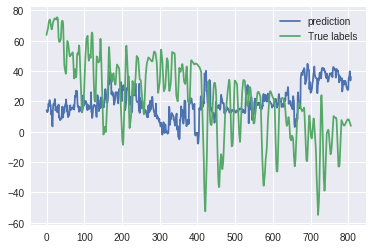

In [126]:
from sklearn.model_selection import cross_val_score, cross_val_predict

pr = cross_val_predict(clf, X, y, cv=6)

plt.plot(pr)
plt.plot(y)
plt.legend(['prediction', 'True labels'])


In [127]:
print(sqrt(sk.metrics.mean_squared_error(y,pr)))

32.32168503358566


# Nice!

In [279]:
pipeline_optimizer.export('tpot_exported_pipeline_riemann2.py')